## Contents 

1 Task  

2 Unzip data

3 Load Data from XML files

4 Create Train and test Dataframe

5 Preprocessing

    1 Why not to remove special characters 
    2 why not to remove stop words

6 EDA
    
    1 class label
    2 Sentence Length
    3 Vocabolary analysis
    4 word length

7 Metrics

8 CNN based Model

    * Architecture 1 
    * Architecture 2

9 LSTM based model 

    * Tokenization 
    * Metrics 
    * LSTM Model
    * LSTM with attention Model
    * Bi-LSTM Model
    * Bi-LSTM with attention Model

10  Model summary

11 ALBERT model

In [ ]:
from bs4 import BeautifulSoup 
import re
import pandas as pd
from sklearn.utils import shuffle
from numpy import array
from numpy import asarray
from numpy import zeros
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import seaborn as sns
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,BatchNormalization,LSTM
from keras.layers import Flatten ,Dropout
from keras.layers import Embedding
from keras.models import Model
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.metrics import roc_auc_score, auc
from keras.layers import Bidirectional
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense , Conv1D,Input
from keras.layers import MaxPooling1D,GlobalMaxPooling1D
from keras.layers import  concatenate
import tensorflow as tf
import keras
from keras.optimizers import Adam
import tensorflow as tf
from keras.utils import plot_model
from keras.layers import Layer
from sklearn.metrics import roc_auc_score , f1_score
import string

## 1 Task

Given a sentence classify the sentence into one of the two class

 1 no-edit i.e. the sentence is correct and contains no mistake

 2 edit    i.e. the sentence is incorrect
  

In [ ]:
!wget --header 'Host: textmining.lt' --user-agent 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'http://textmining.lt/aesw/aesw2016down.html' --header 'Upgrade-Insecure-Requests: 1' 'http://textmining.lt/aesw/aesw2016(v1.2)_train.xml.bz2' --output-document 'aesw2016(v1.2)_train.xml.bz2'

--2021-04-19 07:26:40--  http://textmining.lt/aesw/aesw2016(v1.2)_train.xml.bz2
Resolving textmining.lt (textmining.lt)... 79.98.27.56
Connecting to textmining.lt (textmining.lt)|79.98.27.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751529 (42M) [application/x-bzip2]
Saving to: ‘aesw2016(v1.2)_train.xml.bz2’

aesw2016(v1.2)_trai 100%[===================>]  41.72M  4.04MB/s    in 17s     

2021-04-19 07:26:59 (2.39 MB/s) - ‘aesw2016(v1.2)_train.xml.bz2’ saved [43751529/43751529]



##2  Unzip data

In [ ]:
!wget --header 'Host: textmining.lt' --user-agent 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'http://textmining.lt/aesw/aesw2016down.html' --header 'Upgrade-Insecure-Requests: 1' 'http://textmining.lt/aesw/aesw2016(v1.2)_train.xml.bz2' --output-document 'aesw2016(v1.2)_train.xml.bz2'

--2021-04-19 07:56:45--  http://textmining.lt/aesw/aesw2016(v1.2)_train.xml.bz2
Resolving textmining.lt (textmining.lt)... 79.98.27.56
Connecting to textmining.lt (textmining.lt)|79.98.27.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751529 (42M) [application/x-bzip2]
Saving to: ‘aesw2016(v1.2)_train.xml.bz2’

aesw2016(v1.2)_trai 100%[===================>]  41.72M  3.50MB/s    in 17s     

2021-04-19 07:57:03 (2.49 MB/s) - ‘aesw2016(v1.2)_train.xml.bz2’ saved [43751529/43751529]



In [ ]:
!bunzip2 '/content/aesw2016(v1.2)_train.xml.bz2'

bunzip2: Output file /content/aesw2016(v1.2)_train.xml already exists.


In [ ]:
!unzip '/content/aesw2016(v1.2)_test.xml.zip'

Archive:  /content/aesw2016(v1.2)_test.xml.zip
  inflating: aesw2016(v1.2)_test.xml  


##3 Load Data from XML files



Dataset Website Link : http://textmining.lt/aesw/

http://textmining.lt/aesw/aesw2016down.html

<br>

The data is in XML format and each sentence contains 3 tags

           1 < sentence> with sentence ID at the start and end of sentence

           2 < ins> tag in between sentence

           3 < del> tags in between the sentence
           


In [ ]:
EXAMPLE :


<sentence sid=1>The schedule timetable acts as a manager that <del>control</del> <ins>controls</ins> information traffic</sentence>

After Extracting sentences using BeautifulSoup Fom XML file , we get



    => The schedule timetable acts as a manager that < del> control < /del > < ins>controls< /ins> information traffic

which is converted into two sentences <br><br>

    1 Remove del tag
    => The schedule timetable acts as a manager that <ins>controls</ins> information traffic

    i.e. the new sentence =>  The schedule timetable acts as a manager that controls information traffic


    2 Remove ins tag 
    => The schedule timetable acts as a manager that <del> control </del> information traffic

    i.e. the new sentence => The schedule timetable acts as a manager that control information traffic


Sentence 1 belongs to Label 0 ( no-edit as it contains no mistakes)


Sentence 2 belongs to Label 1 (edit as it contains misatake)

In [ ]:
def extract_sentences(path) :

  with open(path, 'r') as f: 
      data = f.read() 
  
  sentences = []

  Bs_data = BeautifulSoup(data,"xml") 
  b_unique = Bs_data.find_all('sentence') 

  for item in b_unique :
    sentences.append(item)
 
  return sentences

In [ ]:
def process(sentences) :

  class_edit = []
  class_no_edit = []

  for sentence in sentences :

    string = str(sentence)
    string = re.sub('<sentence sid=".*?">','',string) #Remove   <sentence> tag
    string = re.sub('</sentence>','',string)          #Remove   </sentence> tag
  
    s1 = str(string)
    s2 = str(string)

    insert = s1.find('<ins>')
    delete = s1.find('<del>')

    if (insert==-1 and delete==-1) :             #if the sentence has no <ins> , <del> tag skip them
          continue
    
    else :

          s1 = re.sub('<del>.*?</del>','',s1)    #Remove data inbetween <del> ...</del> 
          s1 = re.sub('<ins>','',s1)             #and replace <ins> tag with white space
          s1 = re.sub('</ins>','',s1) 
          s1 = s1.strip()


          s2 = re.sub('<ins>.*?</ins>','',s2)     #Remove data inbetween <ins> ...</ins>
          s2 = re.sub('<del>','',s2)             #and replace <del> tag with white space
          s2 = re.sub('</del>','',s2) 
          s2 = s2.strip()


          if s1==s2 :                            #To avoid adding same sentence to both class
              continue                           #some sentences are like...   <ins>or</ins> <del>or</or>
          
          else :
            class_no_edit.append(s1.lower())
            class_edit.append(s2.lower())

      
  return class_edit,class_no_edit

In [ ]:
train_sentences = extract_sentences('/content/aesw2016(v1.2)_train.xml')
train_class_edit,train_class_no_edit = process(train_sentences)

train_X = train_class_edit + train_class_no_edit

print('Train Data')
print('class  edit    : ',len(train_class_edit))
print('class  no-edit : ',len(train_class_no_edit))
print('Train data     : ',len(train_X))

Train Data
class  edit    :  466666
class  no-edit :  466666
Train data     :  933332


In [ ]:
test_sentences = extract_sentences('/content/aesw2016(v1.2)_test.xml')
test_class_edit,test_class_no_edit = process(test_sentences)

test_X = test_class_edit+test_class_no_edit

print('Test Data')
print('class  edit    : ',len(test_class_edit))
print('class  no-edit : ',len(test_class_no_edit))
print('Train data     : ',len(test_X))

##4 Create Train and Test dataframe

In [ ]:
#Create labels for train data

train_y_edit = [1]*len(train_class_edit)
train_y_no_edit = [0]* len(train_class_no_edit)

train_y = train_y_edit + train_y_no_edit

In [ ]:
#Create labels for test data

test_y_edit = [1]* len(test_class_edit)
test_y_no_edit = [0]* len(test_class_no_edit)

test_y = test_y_edit + test_y_no_edit

In [ ]:
train = pd.DataFrame()
train['data']=train_X
train['class']=train_y

train = train.sample(frac=1).reset_index(drop=True) #Shuffle Labels

In [ ]:
test = pd.DataFrame()
test['data']=test_X
test['class']=test_y

test = test.sample(frac=1).reset_index(drop=True) #Shuffle Labels

In [ ]:
train.head(5)

,data,class
0,the production cross section for _math_- and _...,0
1,"as eulers method has a simple, clear structure...",1
2,many entropy coding techniques exist in litera...,1
3,"on the other hand, the boundary of _math_ is t...",1
4,theorem _ref_(i) demonstrates that when the ch...,0


## 5 Preprocessing

Why not to remove Special Characters during preprocessing ?

    Since the task is to identify senences which needs , the special characters  should not be removed in this task 
 
    Example from train data:


   

    

In [ ]:
using historical benchmarks is the easiest approach <ins> , </ins> but must be taken with care

    This sentence will be converted as :

    Needs edit => using historical benchmarks is the easiest approach but must be taken with care

    Needs no edit => using historical benchmarks is the easiest approach, but must be taken with care

    If in preprocessing and tokenization special characters like - , ;  ' are removed then both sentences becomes same

Why not to remove the Stopwords for this task ?

    Stop words also should not be removed for this task because many sentences 
    needs edit sentences has missing stopwords such as 'is' , 'and' if 
    stopwrods are removed then both edit and no_edit sentences becomes equal

In [ ]:
#strip html tags from data if present 

import re
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub(' ', data)

In [ ]:
#remove URL's from data

def replaceURL(data) :

  data = re.sub(r'http\S+',' ', data)

  return data

In [ ]:
#The vocabolary has the following special words

1 _math_        #_math_ corresponds to a mathematical equation
2 _cite_        #coresponds to citation       
3 _ref_,        #Corrresponds to reference
4 _mathdisp_    #Corresponds to maths

In [ ]:
import re
def special_vocab(data):

    
    p = re.compile(r'_MATH_')
    data =  p.sub(' math ', data)

    p = re.compile(r'_MATHDISP_')
    data =  p.sub(' math ', data)

    p = re.compile(r'_REF_')
    data =  p.sub(' ref ', data)

    p = re.compile(r'_CITE_')
    data =  p.sub(' cite ', data)

    p = re.compile(r'_math_')
    data =  p.sub(' math ', data)

    p = re.compile(r'_mathdisp_')
    data =  p.sub(' math ', data)

    p = re.compile(r'_ref_')
    data =  p.sub(' ref ', data)

    p = re.compile(r'_cite_')
    data =  p.sub(' cite ', data)

    data = " ".join(data.split())

    return data

Consider the following sentences

 1  .... any pointer moves of the neighbors.

 2  ... using historical benchmarks is the easiest approach, but must be taken with care

 when tokenization since there is no space between 'neighors' and ' . ' , we get ' neighbors. ' as a token

 smilarly, for 2nd sentence we get ' approach, ' as a token instead of ' approach ' and ' , ' as two separate token

 so insert space before and after special characters to separate them from words

In [ ]:
# vocab dictionary contains alphabets and numbers
vocab ={}


for i in string.ascii_letters :
  vocab[i]=1

numbers="0123456789"

for i in numbers :
  vocab[i]=1

In [ ]:
def special_character(data):

    new_data = ""

    for char in data :

      if char==' ' :
        new_data = new_data + ' '
      
      else :

        if char not in vocab :        #If the character is not in vocab dictinaary , insert space infront and backs
          new_data = new_data + ' ' + char + ' '
        else :
          new_data = new_data + char

    new_data = " ".join(new_data.split())

    new_data = new_data.strip()


    return new_data

In [ ]:
def preprocess(df) :

  text = []

  for index , row in df.iterrows():
    data = striphtml(row['data'])
    data = replaceURL(data)
    data  = special_vocab(data)
    data = special_character(data)
    text.append(data)

  df['data']=text

  return df

In [ ]:
train = preprocess(train)
#test  = preprocess(test)

In [ ]:
train.head()

,data,class
0,the production cross section for math - and ma...,0
1,"as eulers method has a simple , clear structur...",1
2,many entropy coding techniques exist in litera...,1
3,"on the other hand , the boundary of math is th...",1
4,theorem ref ( i ) demonstrates that when the c...,0


##6 Exploratory Data Analysis

### Class Label

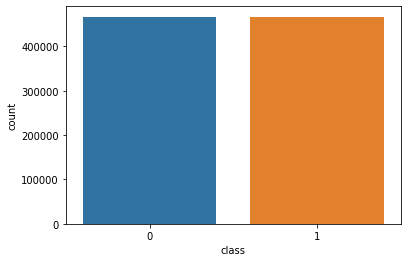

In [ ]:
sns.countplot(data = train, x = 'class')

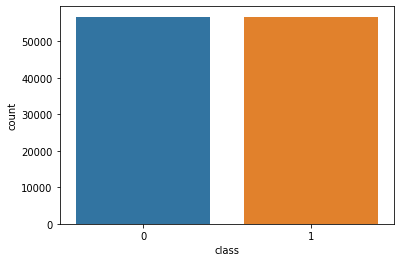

In [ ]:
sns.countplot(data = test, x = 'class')

In [ ]:
train['class'].value_counts()

1    466666
0    466666
Name: class, dtype: int64

In [ ]:
test['class'].value_counts()

1    56740
0    56740
Name: class, dtype: int64

Observation :

1  The count plot data shows the data is balanced

### Sentence Length

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
def Sentence_length(df,data) :

    sentences_length = []

    for sentence in data :
      sentences_length.append(len(sentence))

    sns.distplot(sentences_length)

    plt.figure(figsize=(7,5))
    df['length']=sentences_length
    sb.boxplot(data=df,x='class',y='length')

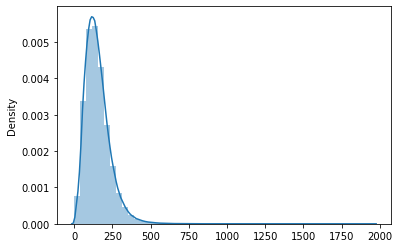

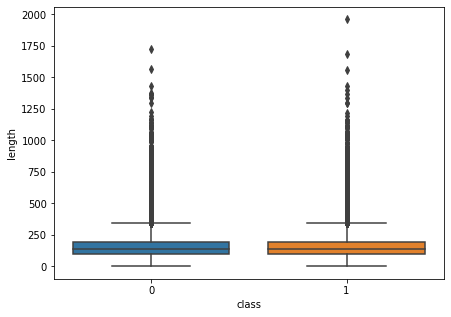

In [ ]:
Sentence_length(train,train['data'])

Distribution Plot 

1 The plot on x axis streches upto 1750 but the peak is in between 0-300

2 The distribution of data shows that most of the data lies between 0-300


Box Plot 

1 The 25th , 50th and 75th percentile of class 1 are same in camparison with class 0


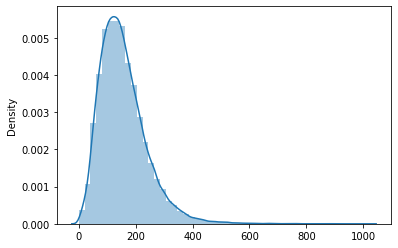

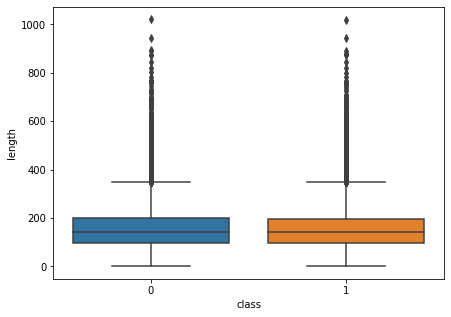

In [ ]:
Sentence_length(test,test['data'])

Distribution Plot 

1 The plot on x axis streches more than 1000 but the peak is in between 0-250

2 The distribution of data shows that most of the data lies between 0-250


Box Plot 

1 The 25th , 50th and 75th percentile of class 1 are same camparison with class 0


### Vocabolary Analysis

In [ ]:
def vocab_analysis(data):
  vocab = Counter()

  for sentence in data :
    sentence = sentence.split()  
    vocab.update(sentence)
    
  return vocab

In [ ]:
train_vocab = vocab_analysis(train['data'])

In [ ]:
train_vocab.most_common(20) #20 most common words in train vocab

[('the', 1874824),
 ('math', 1520285),
 (',', 1381552),
 ('.', 1139290),
 ('of', 841868),
 ('and', 652251),
 ('in', 525596),
 ('is', 472281),
 ('a', 447664),
 ('-', 434784),
 ('to', 431336),
 (')', 374394),
 ('(', 370628),
 ('for', 308252),
 ('that', 283097),
 ('we', 239898),
 ('ref', 236980),
 ('with', 190273),
 ('by', 186575),
 ('are', 178372)]

In [ ]:
print('Train Vocabolary Size ',len(train_vocab))

new_vocab = [word for word in train_vocab if train_vocab[word]>1]   #greater one occurance 

print('Train Vocabolary Size (considering occurance greather than 1) ',len(new_vocab))

new_vocab = [word for word in train_vocab if train_vocab[word]>2]   #greater two occurance

print('Train Vocabolary Size (considering occurance greather than 2) ',len(new_vocab))


Train Vocabolary Size  85767
Train Vocabolary Size (considering occurance greather than 1)  76738
Train Vocabolary Size (considering occurance greather than 2)  49563


In [ ]:
test_vocab = vocab_analysis(test['data'])

In [ ]:
test_vocab.most_common(20) #20 most common words in test vocab

[('the', 232320),
 ('math', 185126),
 (',', 170590),
 ('.', 139997),
 ('of', 105965),
 ('and', 81318),
 ('in', 67207),
 ('is', 57269),
 ('a', 55150),
 ('-', 53785),
 ('to', 52914),
 (')', 46792),
 ('(', 46364),
 ('for', 37243),
 ('that', 35025),
 ('we', 29407),
 ('ref', 29368),
 ('with', 24443),
 ('by', 23793),
 ('as', 21783)]

In [ ]:
print('Test Vocabolary Size ',len(test_vocab))

new_vocab = [word for word in train_vocab if test_vocab[word]>1]   #atleast one occurance 

print('Test Vocabolary Size (considering occurance greather than 1) ',len(new_vocab))

new_vocab = [word for word in train_vocab if test_vocab[word]>2]   #atleast twice occurance

print('Test Vocabolary Size (considering occurance greather than 2) ',len(new_vocab))


Test Vocabolary Size  28805
Test Vocabolary Size (considering occurance greather than 1)  22307
Test Vocabolary Size (considering occurance greather than 2)  16226


### Word length

In [ ]:
def word_length(vocab) :

  word_length = []

  for word in vocab :
    word_length.append(len(word))

  sns.distplot(word_length)

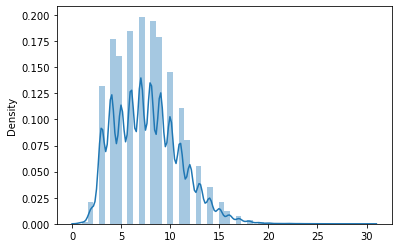

In [ ]:
word_length(train_vocab)

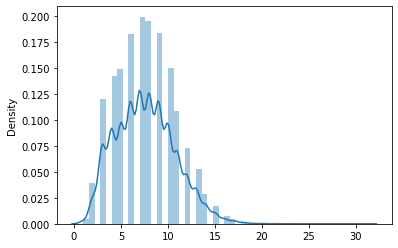

In [ ]:
word_length(test_vocab)

## Metrics

In [ ]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [ ]:
def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_ = true_positives / (possible_positives + K.epsilon())
    return recall_

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_ = true_positives / (predicted_positives + K.epsilon())
    return precision_

def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [ ]:
def getF1Score(model) :
  y_pred = model.predict(X_test_data)
  y_pred = np.argmax(y_pred,axis=1)
  val = f1_score(test['class'], y_pred, average='micro') 
  return val

In [ ]:
class F1Score(tf.keras.callbacks.Callback): 
  
  def on_train_begin(self, logs={}):
    self.history={'F1':[],'val_accuracy': []} 
  
  def on_epoch_end(self, epoch, logs={}):

    f1 = getF1Score(self.model)
    self.history['F1'].append(f1)
    print('F1 Score',f1)

score = F1Score()

## CNN Models

In [ ]:
tokenizer = Tokenizer(filters='\t\n')
tokenizer.fit_on_texts(train['data'])

X_train_data = tokenizer.texts_to_sequences(train['data'])
X_test_data = tokenizer.texts_to_sequences(test['data'])

In [ ]:
X_train_data = pad_sequences(X_train_data, maxlen=128, padding='post')
X_test_data  = pad_sequences(X_test_data, maxlen=128, padding='post')

In [ ]:
num_words = len(tokenizer.word_index) + 1 

### Architecture 1

In [ ]:
keras.backend.clear_session()

sequence_input = Input(shape=(128,), dtype='int32')

embedded_sequences = Embedding(num_words,32,input_length=128)(sequence_input)

x = Conv1D(filters = 16, kernel_size = 7, activation='relu')(embedded_sequences)
y = Conv1D(filters = 16, kernel_size = 7, activation='relu')(embedded_sequences)
z = Conv1D(filters = 16, kernel_size = 7, activation='relu')(embedded_sequences)

x = concatenate([x,y,z])
out = MaxPooling1D(2)(x)

x = Conv1D(filters = 16, kernel_size = 5, activation='relu')(out)
y = Conv1D(filters = 16, kernel_size = 5, activation='relu')(out)
z = Conv1D(filters = 16, kernel_size = 5, activation='relu')(out)

x = concatenate([x,y,z])
x = MaxPooling1D(2)(x)

x = Conv1D(filters = 32, kernel_size = 3, activation='relu')(x)
x = Flatten()(x)

x = Dropout(.5)(x)

x = Dense(256,activation='relu')(x)
x = Dropout(.5)(x)

x = Dense(128,activation='relu')(x)

preds = Dense(2,activation='softmax')(x) 

model1 = Model(sequence_input, preds)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 32)      2744576     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 122, 16)      3600        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 122, 16)      3600        embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 32)      2744576     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 122, 16)      3600        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 122, 16)      3600        embedding[0][0]                  
______________________________________________________________________________________________

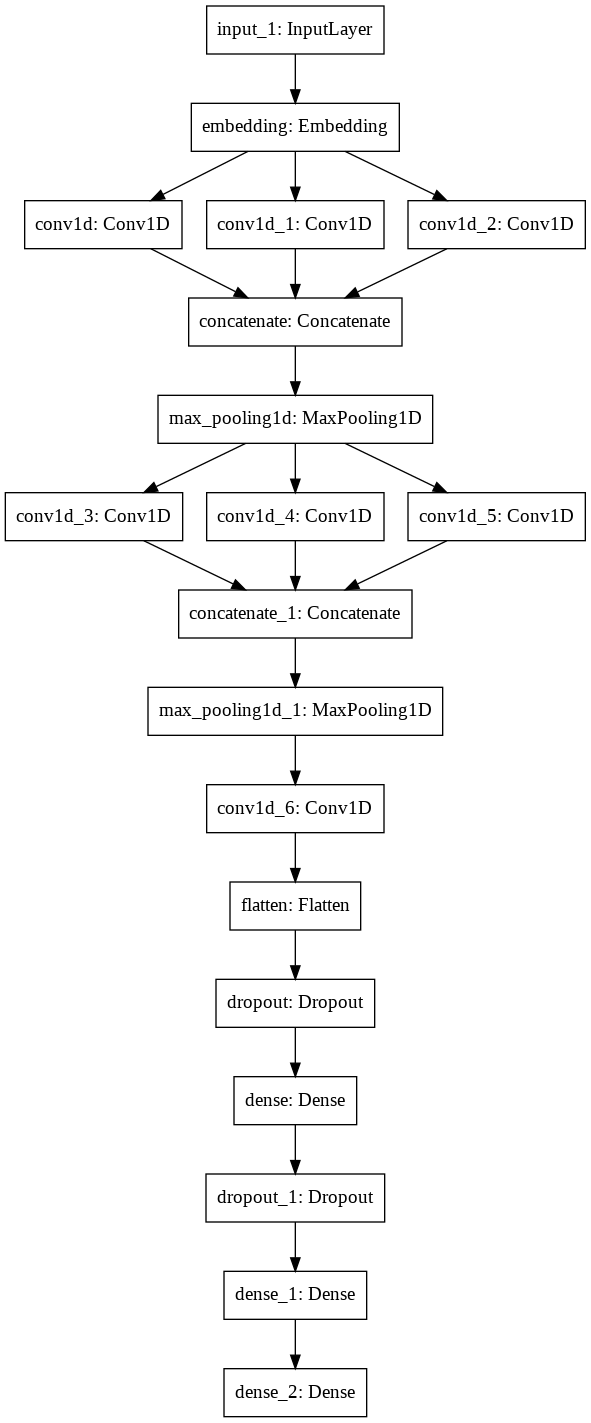

In [ ]:
plot_model(model1)

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',auc])

In [ ]:
model1.fit(X_train_data, to_categorical(train['class']),
          batch_size=128, epochs=5,
          validation_data=(X_test_data, to_categorical(test['class'])),
          callbacks=[score])

Epoch 1/5
7292/7292 [==============================] - 316s 43ms/step - loss: 0.6764 - acc: 0.5593 - auc: 0.5883 - val_loss: 0.6413 - val_acc: 0.6223 - val_auc: 0.6843
F1 Score 0.6222858653507226
Epoch 2/5
7292/7292 [==============================] - 328s 45ms/step - loss: 0.6288 - acc: 0.6354 - auc: 0.6959 - val_loss: 0.6283 - val_acc: 0.6396 - val_auc: 0.7015
F1 Score 0.6395840676771237
Epoch 3/5
7292/7292 [==============================] - 321s 44ms/step - loss: 0.6096 - acc: 0.6557 - auc: 0.7215 - val_loss: 0.6217 - val_acc: 0.6475 - val_auc: 0.7081
F1 Score 0.6475149806133239
Epoch 4/5
7292/7292 [==============================] - 331s 45ms/step - loss: 0.5934 - acc: 0.6697 - auc: 0.7406 - val_loss: 0.6236 - val_acc: 0.6482 - val_auc: 0.7098
F1 Score 0.6481758900246739
Epoch 5/5
7292/7292 [==============================] - 330s 45ms/step - loss: 0.5783 - acc: 0.6829 - auc: 0.7573 - val_loss: 0.6239 - val_acc: 0.6480 - val_auc: 0.7100
F1 Score 0.6480348960169193


### Architecutre 2

In [ ]:
keras.backend.clear_session()

sequence_input = Input(shape=(128,), dtype='int32')

embedded_sequences = Embedding(num_words,32,input_length=128)(sequence_input)

x = Conv1D(filters = 16, kernel_size = 16, activation='relu')(embedded_sequences)
x = Conv1D(filters = 16, kernel_size = 16, activation='relu')(x)
x = MaxPooling1D(2)(x)


x = Conv1D(filters = 32, kernel_size = 7, activation='relu')(x)
x = Conv1D(filters = 32, kernel_size = 7, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(filters = 64, kernel_size = 3, activation='relu')(x)

x = Flatten()(x)

x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(128,activation='relu')(x)
preds = Dense(2,activation='softmax')(x) 

model2 = Model(sequence_input, preds)


In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           2744576   
_________________________________________________________________
conv1d (Conv1D)              (None, 113, 16)           8208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 16)            4112      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 43, 32)            3616      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 32)            7200  

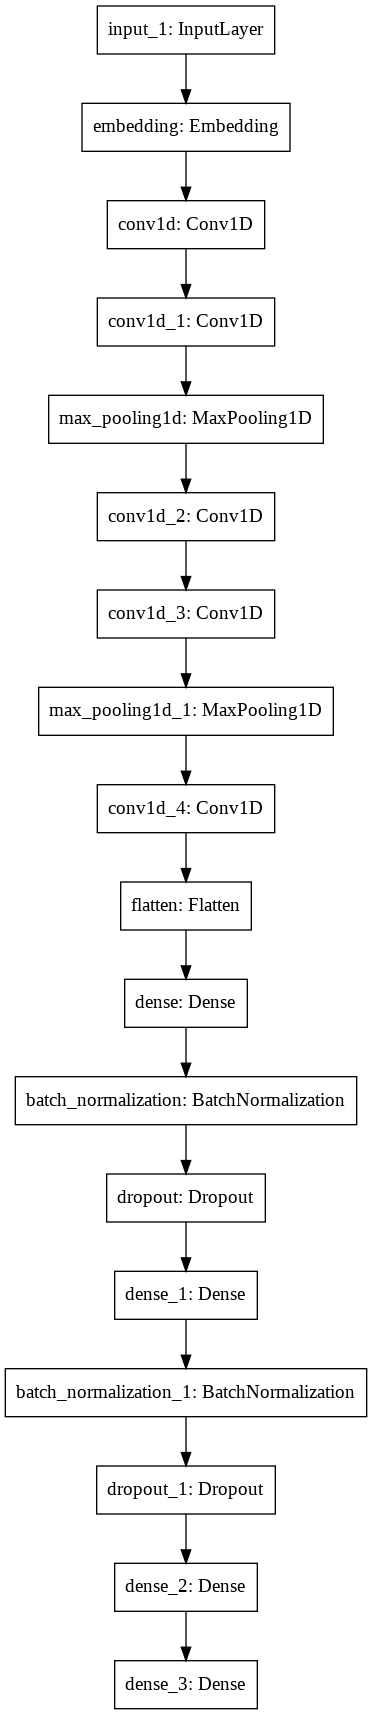

In [ ]:
plot_model(model2)

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',auc,f1,precision, recall])

In [ ]:
model2.fit(X_train_data, to_categorical(train['class']),
          batch_size=128, epochs=4,
          validation_data=(X_test_data, to_categorical(test['class'])))

Epoch 1/4
7292/7292 [==============================] - 240s 33ms/step - loss: 0.6983 - acc: 0.5015 - auc: 0.5027 - f1: 0.5015 - precision: 0.5015 - recall: 0.5015 - val_loss: 0.7256 - val_acc: 0.5025 - val_auc: 0.6067 - val_f1: 0.5025 - val_precision: 0.5025 - val_recall: 0.5025
Epoch 2/4
7292/7292 [==============================] - 242s 33ms/step - loss: 0.6641 - acc: 0.5921 - auc: 0.6331 - f1: 0.5921 - precision: 0.5921 - recall: 0.5921 - val_loss: 0.6484 - val_acc: 0.6099 - val_auc: 0.6831 - val_f1: 0.6098 - val_precision: 0.6098 - val_recall: 0.6098
Epoch 3/4
7292/7292 [==============================] - 244s 33ms/step - loss: 0.6303 - acc: 0.6350 - auc: 0.6937 - f1: 0.6350 - precision: 0.6350 - recall: 0.6350 - val_loss: 0.6310 - val_acc: 0.6348 - val_auc: 0.6940 - val_f1: 0.6348 - val_precision: 0.6348 - val_recall: 0.6348
Epoch 4/4
7292/7292 [==============================] - 244s 33ms/step - loss: 0.6118 - acc: 0.6535 - auc: 0.7195 - f1: 0.6535 - precision: 0.6535 - recall: 0.65

## 7 LSTM based Model

### Tokenization

In [ ]:
tokenizer = Tokenizer(filters='\t\n')
tokenizer.fit_on_texts(train['data'])

X_train_data = tokenizer.texts_to_sequences(train['data'])
X_test_data = tokenizer.texts_to_sequences(test['data'])

In [ ]:
X_train_data = pad_sequences(X_train_data, maxlen=128, padding='post')
X_test_data  = pad_sequences(X_test_data, maxlen=128, padding='post')

In [ ]:
num_words = len(tokenizer.word_index ) + 1

In [ ]:
import pickle

In [ ]:
#dump tokenizer
pickle.dump((tokenizer),open('tokenizer.pkl','wb'))

### LSTM Model :     



In [ ]:
keras.backend.clear_session()

input_sentence        = Input(shape=(128,), dtype='int32') 

sentence         = Embedding(num_words,32,input_length=128) (input_sentence)
sentence         = LSTM(100)(sentence)

x = Dense(64,activation='relu')(sentence)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(8,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(4,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

preds = Dense(2,activation='softmax')(x) 

lstm_model = Model(inputs =input_sentence, outputs = preds)

In [ ]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           2744576   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520   

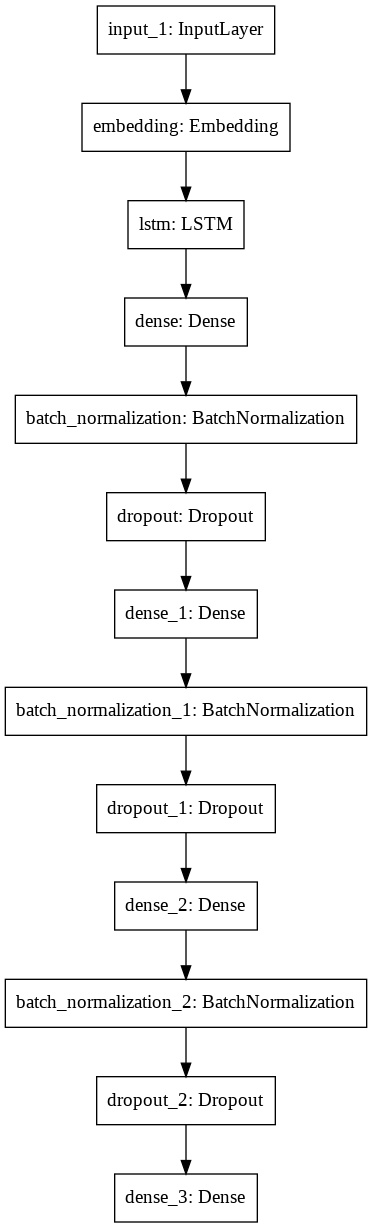

In [ ]:
plot_model(lstm_model)

In [ ]:
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.01),metrics=['acc',auc,f1,precision, recall])

In [ ]:
lstm_model.fit(X_train_data, to_categorical(train['class']),
            batch_size=128, epochs=5,
            validation_data=(X_test_data, to_categorical(test['class'])))

Epoch 1/5
7292/7292 [==============================] - 271s 37ms/step - loss: 0.7046 - acc: 0.4989 - auc: 0.4990 - f1: 0.4989 - precision: 0.4989 - recall: 0.4988 - val_loss: 0.6935 - val_acc: 0.5000 - val_auc: 0.5013 - val_f1: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/5
7292/7292 [==============================] - 270s 37ms/step - loss: 0.6935 - acc: 0.4990 - auc: 0.5003 - f1: 0.4990 - precision: 0.4990 - recall: 0.4990 - val_loss: 0.6934 - val_acc: 0.5000 - val_auc: 0.5012 - val_f1: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/5
7292/7292 [==============================] - 269s 37ms/step - loss: 0.6934 - acc: 0.5000 - auc: 0.4993 - f1: 0.5000 - precision: 0.5000 - recall: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.4983 - val_f1: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/5
7292/7292 [==============================] - 270s 37ms/step - loss: 0.6934 - acc: 0.5009 - auc: 0.5005 - f1: 0.5009 - precision: 0.5009 - recall: 0.50

### LSTM with attention

In [ ]:
#Code link
#https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
keras.backend.clear_session()

input_sentence        = Input(shape=(128,), dtype='int32') 

sentence         = Embedding(num_words,32,input_length=128) (input_sentence)
sentence         = LSTM(100,return_sequences=True)(sentence)

x = attention()(sentence)

x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(.5)(x)

x = Dense(8,activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(.5)(x)

x = Dense(4,activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(.5)(x)

preds = Dense(2,activation='softmax')(x) 

lstm_model_attention = Model(inputs =input_sentence, outputs = preds)

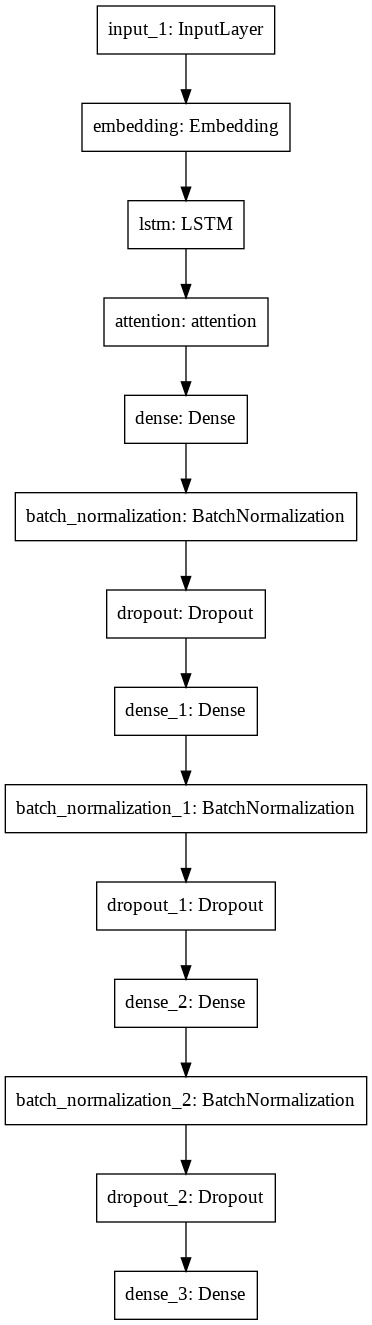

In [ ]:
plot_model(lstm_model_attention)

In [ ]:
lstm_model_attention.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           2744576   
_________________________________________________________________
lstm (LSTM)                  (None, 128, 100)          53200     
_________________________________________________________________
attention (attention)        (None, 100)               228       
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

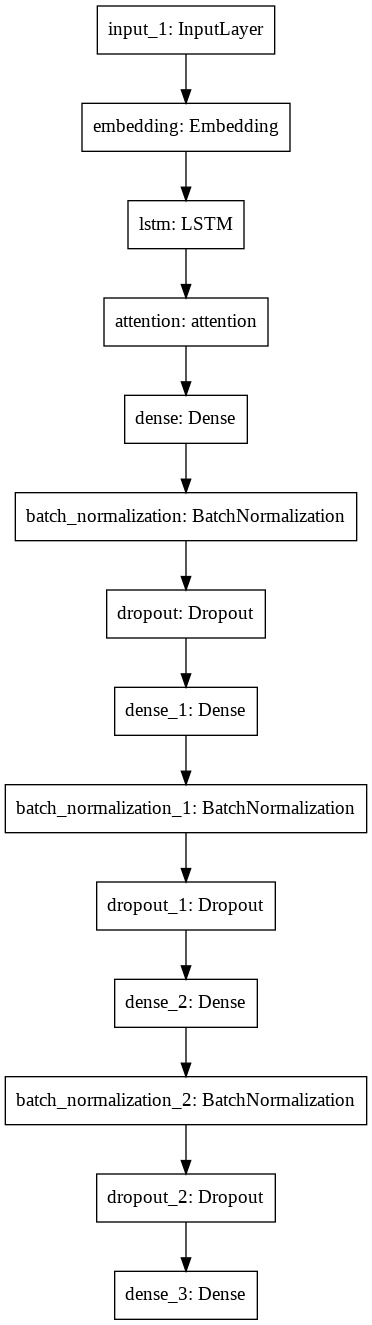

In [ ]:
plot_model(lstm_model_attention)

In [ ]:
lstm_model_attention.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.01),metrics=['acc',auc,f1,precision, recall])

In [ ]:
lstm_model_attention.fit(X_train_data, to_categorical(train['class']),
            batch_size=128, epochs=8,
            validation_data=(X_test_data, to_categorical(test['class'])))

Epoch 1/8
7292/7292 [==============================] - 276s 37ms/step - loss: 0.6990 - acc: 0.5006 - auc: 0.5020 - f1: 0.5006 - precision: 0.5006 - recall: 0.5006 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5053 - val_f1: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/8
7292/7292 [==============================] - 274s 38ms/step - loss: 0.6927 - acc: 0.5085 - auc: 0.5132 - f1: 0.5085 - precision: 0.5085 - recall: 0.5085 - val_loss: 0.6840 - val_acc: 0.5613 - val_auc: 0.5938 - val_f1: 0.5613 - val_precision: 0.5613 - val_recall: 0.5613
Epoch 3/8
7292/7292 [==============================] - 276s 38ms/step - loss: 0.6833 - acc: 0.5592 - auc: 0.5849 - f1: 0.5592 - precision: 0.5592 - recall: 0.5592 - val_loss: 0.6785 - val_acc: 0.5547 - val_auc: 0.6231 - val_f1: 0.5547 - val_precision: 0.5547 - val_recall: 0.5547
Epoch 4/8
7292/7292 [==============================] - 275s 38ms/step - loss: 0.6762 - acc: 0.5757 - auc: 0.6084 - f1: 0.5757 - precision: 0.5757 - recall: 0.57

###Bi-LSTM Model 



In [ ]:
keras.backend.clear_session()

input_sentence        = Input(shape=(128,), dtype='int32') 

sentence         = Embedding(num_words,32,input_length=128) (input_sentence)
sentence         = Bidirectional(LSTM(100))(sentence)

x = Dense(64,activation='relu')(sentence)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(8,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(4,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

preds = Dense(2,activation='softmax')(x) 

bi_lstm_model = Model(inputs =input_sentence, outputs = preds)

In [ ]:
bi_lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           2744576   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520   

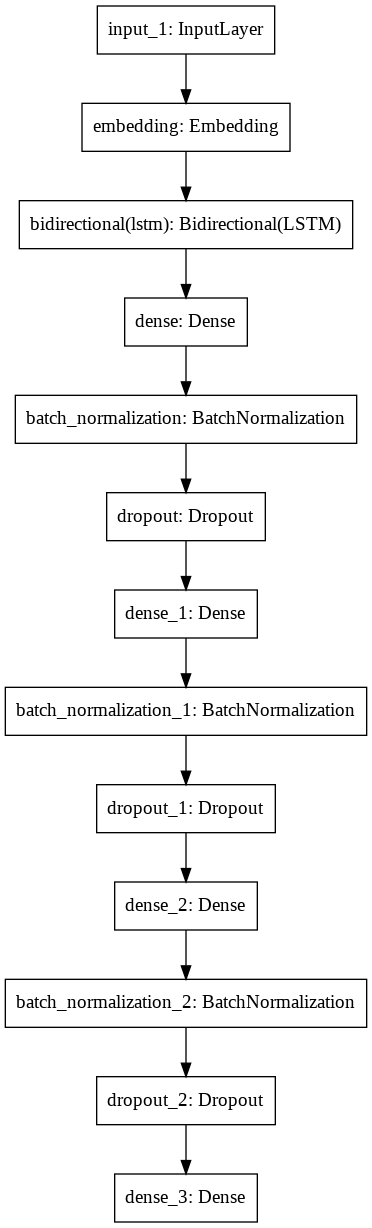

In [ ]:
plot_model(bi_lstm_model)

In [ ]:
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.001),metrics=['acc',auc,f1,precision, recall])

In [ ]:
bi_lstm_model.fit(X_train_data, to_categorical(train['class']),
            batch_size=128, epochs=10,
            validation_data=(X_test_data, to_categorical(test['class'])))

Epoch 1/10
7292/7292 [==============================] - 335s 45ms/step - loss: 0.7247 - acc: 0.5136 - auc: 0.5193 - f1: 0.5136 - precision: 0.5136 - recall: 0.5136 - val_loss: 0.6893 - val_acc: 0.5246 - val_auc: 0.5759 - val_f1: 0.5246 - val_precision: 0.5246 - val_recall: 0.5246
Epoch 2/10
7292/7292 [==============================] - 332s 46ms/step - loss: 0.6807 - acc: 0.5632 - auc: 0.5860 - f1: 0.5632 - precision: 0.5632 - recall: 0.5632 - val_loss: 0.6572 - val_acc: 0.6034 - val_auc: 0.6659 - val_f1: 0.6034 - val_precision: 0.6034 - val_recall: 0.6034
Epoch 3/10
7292/7292 [==============================] - 332s 46ms/step - loss: 0.6541 - acc: 0.6168 - auc: 0.6620 - f1: 0.6168 - precision: 0.6168 - recall: 0.6168 - val_loss: 0.6344 - val_acc: 0.6357 - val_auc: 0.6972 - val_f1: 0.6357 - val_precision: 0.6357 - val_recall: 0.6357
Epoch 4/10
7292/7292 [==============================] - 332s 46ms/step - loss: 0.6366 - acc: 0.6388 - auc: 0.6941 - f1: 0.6388 - precision: 0.6388 - recall: 

### Bi-LSTM with attention

In [ ]:
keras.backend.clear_session()

input_sentence        = Input(shape=(128,), dtype='int32') 

sentence         = Embedding(num_words,32,input_length=128) (input_sentence)
sentence         = Bidirectional(LSTM(100,return_sequences=True))(sentence)

x=attention()(sentence)

x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(8,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(4,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

preds = Dense(2,activation='softmax')(x) 

bi_lstm_model_attention = Model(inputs =input_sentence, outputs = preds)

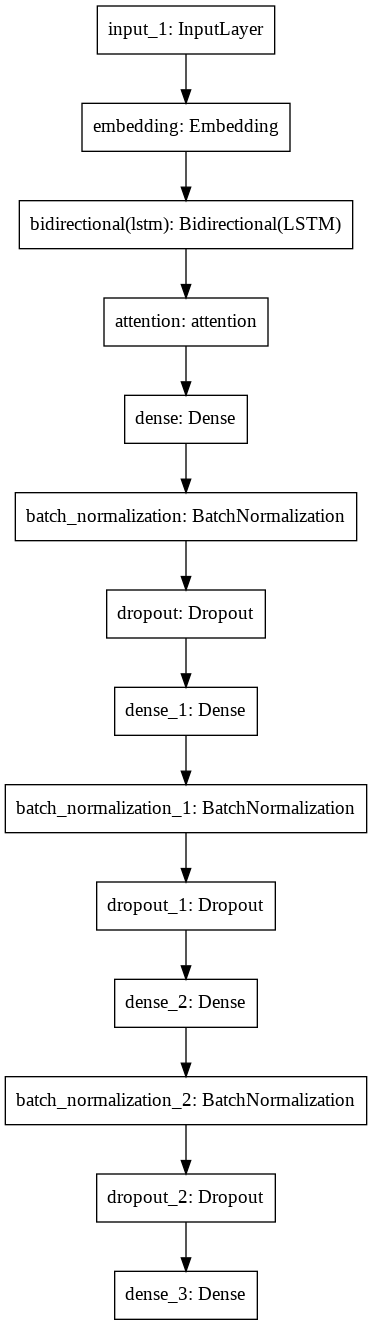

In [ ]:
plot_model(bi_lstm_model_attention)

In [ ]:
bi_lstm_model_attention.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           2744576   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 200)          106400    
_________________________________________________________________
attention (attention)        (None, 200)               328       
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

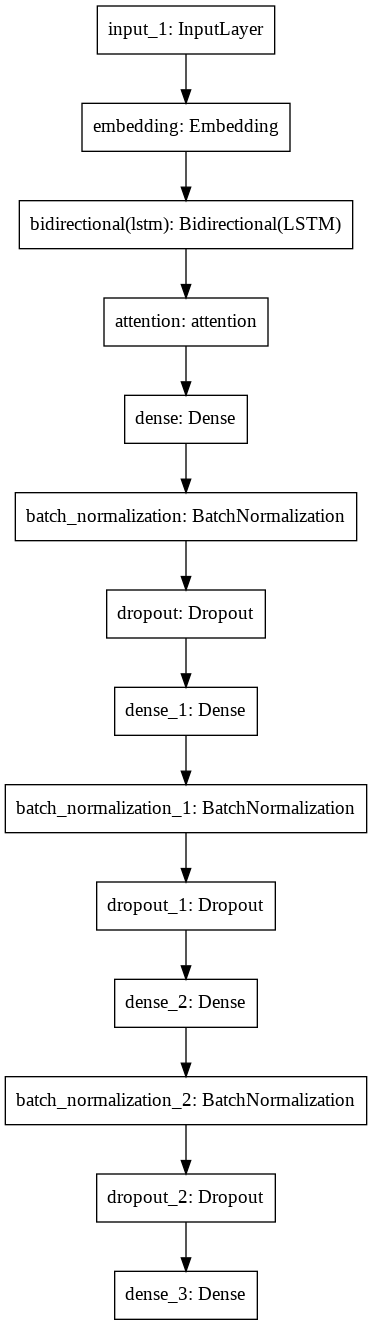

In [ ]:
plot_model(bi_lstm_model_attention)

In [ ]:
bi_lstm_model_attention.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.001),metrics=['acc',auc])

In [ ]:
bi_lstm_model_attention.fit(X_train_data, to_categorical(train['class']),
            batch_size=128, epochs=10,
            validation_data=(X_test_data, to_categorical(test['class'])),
            callbacks=[score])

Epoch 1/10
7292/7292 [==============================] - 368s 46ms/step - loss: 0.7540 - acc: 0.5087 - auc: 0.5130 - val_loss: 0.6790 - val_acc: 0.5689 - val_auc: 0.5943
F1 Score 0.5689020091646105
Epoch 2/10
7292/7292 [==============================] - 336s 46ms/step - loss: 0.6786 - acc: 0.5709 - auc: 0.5948 - val_loss: 0.6638 - val_acc: 0.5754 - val_auc: 0.6691
F1 Score 0.575422982023264
Epoch 3/10
7292/7292 [==============================] - 334s 46ms/step - loss: 0.6520 - acc: 0.6191 - auc: 0.6666 - val_loss: 0.6337 - val_acc: 0.6312 - val_auc: 0.6978
F1 Score 0.6311508635882975
Epoch 4/10
7292/7292 [==============================] - 349s 48ms/step - loss: 0.6338 - acc: 0.6420 - auc: 0.6991 - val_loss: 0.6324 - val_acc: 0.6210 - val_auc: 0.7154
F1 Score 0.6209552344025379
Epoch 5/10
7292/7292 [==============================] - 344s 47ms/step - loss: 0.6198 - acc: 0.6557 - auc: 0.7203 - val_loss: 0.6157 - val_acc: 0.6547 - val_auc: 0.7211
F1 Score 0.6546704265068735
Epoch 6/10
7292/

In [ ]:
#SAVE the model

bi_lstm_model_attention.save('bi_lstm_with_attention.h5')

## Summary

In [ ]:
def confusion_matrixx(model) :
    predictions = model.predict(test['data'])
    y_pred = np.argmax(predictions, axis=1)
    matrix = confusion_matrix(test['class'], y_pred)
    print(matrix)

### CNN models

CNN model1 

Accurcy = .6484   AUC = .7073

F1 = .6484 Precision .6484 Recall = .6484

CNN model 2

Accuracy = .6328 AUC = .6998

F1 = .6327 Precision = .6327 Recall = .6327

### LSTM models

LSTM Model

Accuary = .50    AUC = .50

F1 Score = .50   Precison = .50 Recall = .50

The model classifiy evey sentence as one class , Discard the model

In [ ]:
confusion_matrixx(lstm_model)

[[    0 56740]
 [    0 56740]]


LSTM with attention Model

Accuary  = .5858     AUC = .6412
 
F1 Score = .5858    Precison = .5858 Recall = .5858

LSTM with attention Model words better than vanilla LSTM model

Bi-LSTM 

Accuary = .6629    AUC = .7255
 
F1 Score = .6629   Precison = .6629 Recall = .6629

Bi-LSTM with attention

Accuary = .6632    AUC = .7289
 
F1 Score = .6632   Precison = .6632 Recall = .6632

Bi-LSTM models performs better than LSTM

The attention Mechanism is able to improve vanilla LSTM model

Bi-LSTM model with attention performs better among the 4 models 